<a href="https://colab.research.google.com/github/rosshalpin/AdvancedML/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/AdvancedML/

/content/gdrive/MyDrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/AdvancedML


In [15]:
!pip install tweepy --upgrade

In [16]:
%cd /mydrive/AdvancedML/

/content/gdrive/My Drive/AdvancedML


In [17]:
import tweepy
import pandas as pd

def pre_process_text(text: str) -> str:
    text = text.replace("\n", " ").replace("\t", " ") # removing newlines and tabs
    return text.strip()

def obtain_tweets(topic, max=10, limit=10):
  with open('bearer.txt', 'r') as file:
    BEARER_TOKEN = file.read().rstrip()

  client = tweepy.Client(bearer_token=BEARER_TOKEN)

  tweet_paginator = tweepy.Paginator(client.search_recent_tweets,
                                query=f"{topic} -is:retweet lang:en",
                                tweet_fields=[
                                  "created_at", 
                                  "possibly_sensitive", 
                                  "public_metrics",
                                ],
                                place_fields=[
                                  "full_name",
                                  "geo",
                                  "country",
                                  "country_code"    
                                ],
                                expansions="geo.place_id",
                                max_results=max,
                                limit=limit)

  responses = []
  for resp in tweet_paginator:
    responses.append(resp)

  found_places = {}

  for resp in responses:
    places = resp.includes.get('places')
    if places:
      for place in places:
        found_places[place.id] = place

  tweets = []

  for resp in responses:
    for tweet in resp.data:
      if tweet.geo:
        place_id = tweet.geo.get('place_id')
        coords = found_places[place_id].geo.get('bbox')
        lon = (coords[0]+coords[2])/2
        lat = (coords[1]+coords[3])/2
        new_tweet = [
            found_places[place_id].full_name,
            f"{lat:.2f},{lon:.2f}",
            tweet.created_at, 
            tweet.possibly_sensitive, 
            tweet.public_metrics.get('retweet_count'), 
            tweet.public_metrics.get('reply_count'),
            tweet.public_metrics.get('like_count'),
            tweet.public_metrics.get('quote_count'),
            pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)


  for resp in responses:
    for tweet in resp.data:
      if not tweet.geo and len(tweets) < (max*limit):
        new_tweet = [
          None,
          None,
          tweet.created_at,
          tweet.possibly_sensitive,
          tweet.public_metrics.get('retweet_count'), 
          tweet.public_metrics.get('reply_count'),
          tweet.public_metrics.get('like_count'),
          tweet.public_metrics.get('quote_count'),
          pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)

  columns = ["place", "coords", "created_at", "possibly_sensitive", "retweet_count", "reply_count", "like_count", "quote_count", "text"]
  df = pd.DataFrame(tweets, columns=columns)
  return df

In [18]:
# df = obtain_tweets("Lewis Hamilton", 50, 50)

In [19]:
# %cd /mydrive/AdvancedML/

In [20]:
# import time, csv
# epoch_time = int(time.time())

# df.to_csv("tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [21]:
try:
  df = pd.read_csv("tweets.1650486802.csv")
except:
  df = None

In [22]:
df.head()

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
0,"Port Blandford, Newfoundland and Labrador","48.36,-54.18",2022-04-20 20:18:29+00:00,False,0,0,0,0,@lemieuxdavid I’m curious where that Baba O’Re...,positive
1,"Coventry, England","52.41,-1.52",2022-04-20 17:37:06+00:00,False,4,1,43,0,Lewis Hamilton Fuji 2007… Another one of his ...,positive
2,"Tamworth, England","52.62,-1.68",2022-04-20 12:51:05+00:00,False,0,2,5,0,@MattyWTF1 Fans being openly contemptuous towa...,negative
3,"Sydney, New South Wales","-33.85,150.93",2022-04-20 09:46:10+00:00,False,0,0,0,0,@MattyWTF1 Carlos Sainz contract negotiations ...,neutral
4,Potchefstroom,"-26.26,28.00",2022-04-20 04:48:19+00:00,False,51,2,51,0,Revamp your Cv + Cover letter to attract recr...,neutral


In [23]:
df.shape

(2500, 10)

In [24]:
import matplotlib.pyplot as plt

def print_sentiment_breakdown(sentiments, title):
  label_colors = {
      "neutral": "lightgrey",
      "negative": "orangered",
      "positive": "lightgreen"
  }

  sent_counts = sentiments.value_counts(normalize=True) * 100
  label = sent_counts.keys()
  color= [label_colors[l] for l in label]
  plt.pie(sent_counts, labels=label, colors = color, autopct='%.0f%%')
  plt.title(title)
  plt.show()

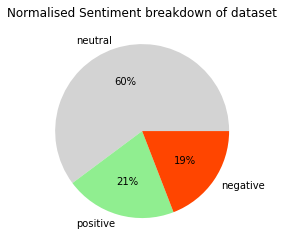

In [25]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset")

In [26]:
import re

def cleanup_data(df):

  def remove_usernames(text):
    return re.sub(r'@([^\s]+)', '', text)

  def remove_hyperlinks(text):
    return re.sub(r'http\S+|www.\S+|https', '', text)

  df.text = df.text.apply(remove_usernames) # removing usernames
  df.text = df.text.apply(remove_hyperlinks) # removing hyperlinks
  df = df.drop(df.query('sentiment == "neutral"').sample(frac=.64, random_state=109).index) # evening out the number of neutral samples by random removing a percentage
  df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True) # removing any errant unicode

  return df

In [27]:
df = cleanup_data(df)

In [28]:
# import time, csv
# epoch_time = int(time.time())
# df.to_csv("cleaned_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

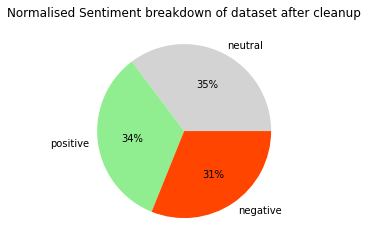

In [29]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset after cleanup")

In [30]:
df.shape

(1537, 10)

# SVM Sentiment Classifier

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    _, (ax) = plt.subplots(1, 1, figsize=(20, 5))
    ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.set_xlabel("training sample")
    ax.set_ylabel("score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

tweet_tokenizer = TweetTokenizer()

def tokenize(input): 
    return tweet_tokenizer.tokenize(input)

def stemmer(input):
  snow_stemmer = SnowballStemmer("english")
  return (snow_stemmer.stem(word) for word in input)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=431, shuffle=True)

vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    lowercase = True,
    stop_words = set(stopwords.words("english")),
    max_features=150
)


X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

clf = svm.SVC(
    kernel='linear',
)
clf.fit(X_train_vectors, y_train)
y_pred = clf.predict(X_test_vectors)

report = classification_report(y_test, y_pred, output_dict=True)
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral ', report['neutral'])

accuracy:  0.564935064935065
macro avg:  {'precision': 0.5666666666666668, 'recall': 0.5651515151515151, 'f1-score': 0.5616161616161616, 'support': 154}
positive:  {'precision': 0.5909090909090909, 'recall': 0.4727272727272727, 'f1-score': 0.5252525252525252, 'support': 55}
negative:  {'precision': 0.45454545454545453, 'recall': 0.5681818181818182, 'f1-score': 0.5050505050505051, 'support': 44}
neutral  {'precision': 0.6545454545454545, 'recall': 0.6545454545454545, 'f1-score': 0.6545454545454545, 'support': 55}


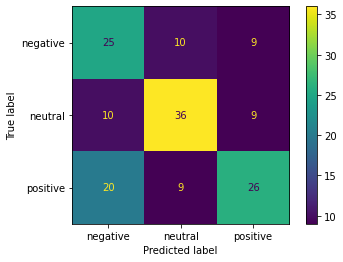

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

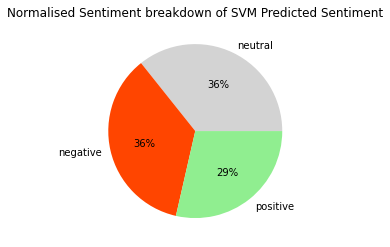

In [35]:
pred_df = pd.DataFrame(y_pred)[0]
print_sentiment_breakdown(pred_df, "Normalised Sentiment breakdown of SVM Predicted Sentiment")

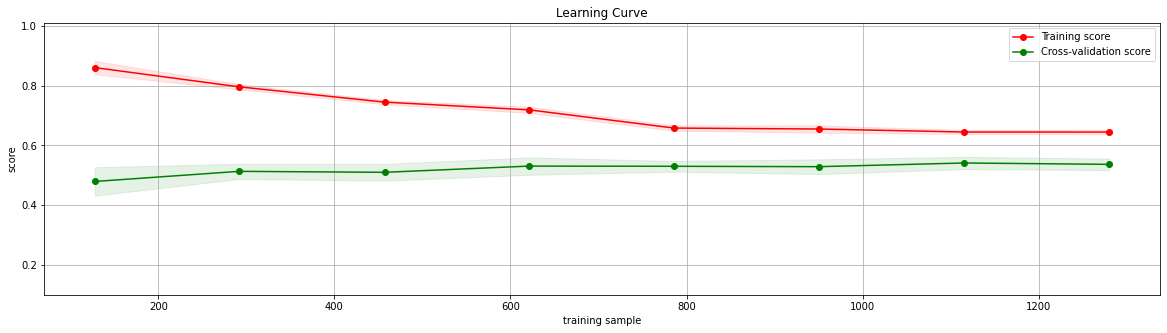

In [36]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

plot_learning_curve(
    clf, 
    "Learning Curve", 
    X=vectorizer.fit_transform(df.text), 
    y=df.sentiment,
    ylim=(0.1, 1.01), 
    cv=folds, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

plt.show()

In [37]:
!pip install vaderSentiment

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_df = pd.DataFrame(X_test).apply(get_sentiment, axis=1)

vader_report = classification_report(vader_df, y_test, output_dict=True)
print('accuracy: ', vader_report['accuracy'])
print('macro avg: ', vader_report['macro avg'])
print('positive: ', vader_report['positive'])
print('negative: ', vader_report['negative'])
print('neutral ', vader_report['neutral'])

accuracy:  0.6493506493506493
macro avg:  {'precision': 0.6454545454545454, 'recall': 0.6819192014313966, 'f1-score': 0.6437719189005701, 'support': 154}
positive:  {'precision': 0.8545454545454545, 'recall': 0.573170731707317, 'f1-score': 0.6861313868613138, 'support': 82}
negative:  {'precision': 0.5909090909090909, 'recall': 0.7428571428571429, 'f1-score': 0.6582278481012659, 'support': 35}
neutral  {'precision': 0.4909090909090909, 'recall': 0.7297297297297297, 'f1-score': 0.5869565217391305, 'support': 37}


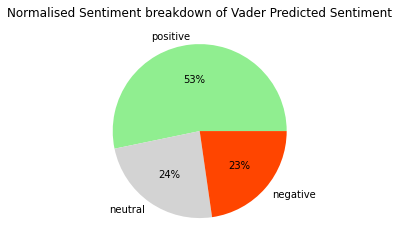

In [39]:
print_sentiment_breakdown(vader_df, "Normalised Sentiment breakdown of Vader Predicted Sentiment")

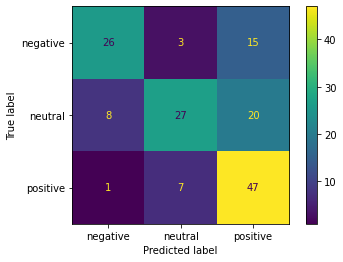

In [40]:
cm = confusion_matrix(y_test, vader_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

In [41]:
vader_df = vader_df.reset_index(drop=True)
vader_df.eq(pred_df).mean() * 100

42.857142857142854

# Comparing SVM and Vader on a different topic

In [42]:
# pol_df = obtain_tweets("Bernie Sanders", 25, 20)

# epoch_time = int(time.time())

# df.to_csv("pol_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [43]:
pol_df = pd.read_csv("pol_tweets.1650715759.csv")

In [44]:
pol_df = cleanup_data(pol_df)

In [45]:
pol_df.sample(10)

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
460,NaN,NaN,2022-04-22 21:03:52+00:00,False,0,0,0,0,3. Bernie Sanders,neutral
293,NaN,NaN,2022-04-22 21:23:46+00:00,False,0,0,0,0,Bernie Sanders I presume? God you people are ...,negative
497,NaN,NaN,2022-04-22 20:57:05+00:00,False,0,0,0,0,3- Bernie Sanders,neutral
482,NaN,NaN,2022-04-22 21:00:07+00:00,False,3,2,10,0,Bernie Sanders torches Congress for considerin...,negative
352,NaN,NaN,2022-04-22 21:19:18+00:00,False,0,0,0,0,3. Bernie Sanders,neutral
147,NaN,NaN,2022-04-22 21:53:01+00:00,False,0,0,0,0,Great project 3) Bernie Sanders,positive
455,NaN,NaN,2022-04-22 21:04:27+00:00,False,0,0,0,0,"""Bread lines are a good thing"" - Bernie Sanders",positive
126,NaN,NaN,2022-04-22 21:57:58+00:00,False,0,0,0,0,"Tells Bernie that without Elon, NASA would no...",neutral
233,NaN,NaN,2022-04-22 21:36:18+00:00,False,0,0,0,0,It's not your place...!!! Never owned a busi...,negative
410,NaN,NaN,2022-04-22 21:11:52+00:00,False,0,0,0,0,Bernie Sanders,neutral


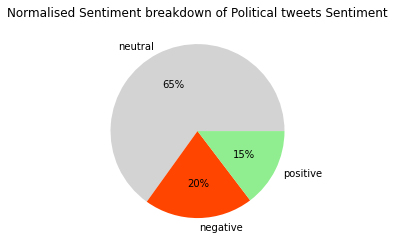

In [46]:
print_sentiment_breakdown(pol_df.sentiment, "Normalised Sentiment breakdown of Political tweets Sentiment")

In [47]:
pol_df.shape

(232, 10)

### Vader Sentiment Analysis

accuracy:  0.7370689655172413
macro avg:  {'precision': 0.6341632891003379, 'recall': 0.6512865726227796, 'f1-score': 0.6269554649230371, 'support': 232}
positive:  {'precision': 0.5588235294117647, 'recall': 0.34545454545454546, 'f1-score': 0.42696629213483145, 'support': 55}
negative:  {'precision': 0.48936170212765956, 'recall': 0.71875, 'f1-score': 0.5822784810126582, 'support': 32}
neutral  {'precision': 0.8543046357615894, 'recall': 0.8896551724137931, 'f1-score': 0.8716216216216217, 'support': 145}


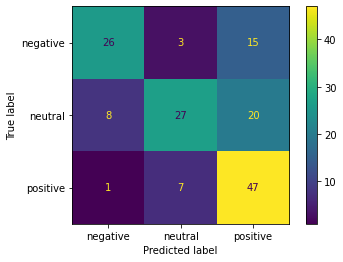

In [48]:
def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_pol_df = pd.DataFrame(pol_df.text).apply(get_sentiment, axis=1)

vader_pol_report = classification_report(vader_pol_df, pol_df.sentiment, output_dict=True)
print('accuracy: ', vader_pol_report['accuracy'])
print('macro avg: ', vader_pol_report['macro avg'])
print('positive: ', vader_pol_report['positive'])
print('negative: ', vader_pol_report['negative'])
print('neutral ', vader_pol_report['neutral'])

cm = confusion_matrix(y_test, vader_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

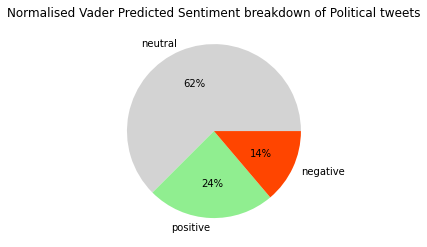

In [49]:
print_sentiment_breakdown(vader_pol_df, "Normalised Vader Predicted Sentiment breakdown of Political tweets")

### SVM Sentiment Analysis

In [50]:
pol_vectors = vectorizer.transform(pol_df.text)

In [51]:
pol_vectors.shape

(232, 150)

accuracy:  0.16810344827586207
macro avg:  {'precision': 0.2155614112135851, 'recall': 0.27550028042779745, 'f1-score': 0.155178952672687, 'support': 232}
positive:  {'precision': 0.21739130434782608, 'recall': 0.14705882352941177, 'f1-score': 0.1754385964912281, 'support': 34}
negative:  {'precision': 0.15656565656565657, 'recall': 0.6595744680851063, 'f1-score': 0.2530612244897959, 'support': 47}
neutral  {'precision': 0.2727272727272727, 'recall': 0.019867549668874173, 'f1-score': 0.03703703703703704, 'support': 151}


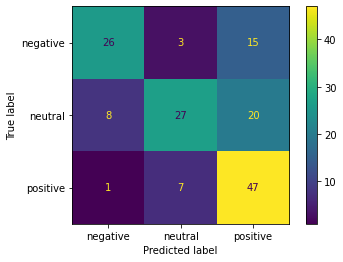

In [52]:
svm_pol_pred = clf.predict(pol_vectors)

svm_pol_report = classification_report(pol_df.sentiment, svm_pol_pred, output_dict=True)
print('accuracy: ', svm_pol_report['accuracy'])
print('macro avg: ', svm_pol_report['macro avg'])
print('positive: ', svm_pol_report['positive'])
print('negative: ', svm_pol_report['negative'])
print('neutral ', svm_pol_report['neutral'])

cm = confusion_matrix(y_test, vader_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

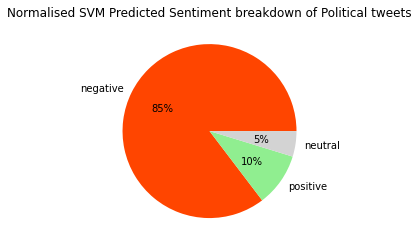

In [53]:
svm_pol_df = pd.DataFrame(svm_pol_pred)[0]

print_sentiment_breakdown(svm_pol_df, "Normalised SVM Predicted Sentiment breakdown of Political tweets")

# Deep Neural Network Sentiment Analysis

In [54]:
df = pd.read_csv("tweets.1650486802.csv")
df = cleanup_data(df)

In [55]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
from numpy.random import seed
seed(1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Y = pd.get_dummies(df.sentiment).values

max_features = 115

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.text)

X = pad_sequences(tokenizer.texts_to_sequences(df.text))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=613, shuffle=True)

In [57]:
import torch
torch.cuda.is_available()

True

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.callbacks import History 
history = History()

embed_dim = 18
lstm_out = 4


model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 42, 18)            2070      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 368       
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                                                                 
Total params: 2,453
Trainable params: 2,453
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [69]:
try:
  with open('history.pickle', 'rb') as handle:
    history2 = pickle.load(handle)
except:
  history2 = None

In [70]:
batch_size = 32
if not history2:
  history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 40, batch_size=batch_size, verbose = 2, callbacks=[history, model_checkpoint_callback])

Epoch 1/40
34/34 - 30s - loss: 1.0971 - accuracy: 0.3386 - val_loss: 1.0916 - val_accuracy: 0.3788 - 30s/epoch - 868ms/step
Epoch 2/40
34/34 - 6s - loss: 1.0852 - accuracy: 0.4372 - val_loss: 1.0793 - val_accuracy: 0.4437 - 6s/epoch - 182ms/step
Epoch 3/40
34/34 - 6s - loss: 1.0659 - accuracy: 0.4605 - val_loss: 1.0579 - val_accuracy: 0.4264 - 6s/epoch - 173ms/step
Epoch 4/40
34/34 - 6s - loss: 1.0413 - accuracy: 0.4567 - val_loss: 1.0304 - val_accuracy: 0.4827 - 6s/epoch - 173ms/step
Epoch 5/40
34/34 - 6s - loss: 1.0122 - accuracy: 0.5051 - val_loss: 1.0075 - val_accuracy: 0.4978 - 6s/epoch - 181ms/step
Epoch 6/40
34/34 - 6s - loss: 0.9846 - accuracy: 0.5405 - val_loss: 0.9870 - val_accuracy: 0.5238 - 6s/epoch - 179ms/step
Epoch 7/40
34/34 - 6s - loss: 0.9564 - accuracy: 0.5693 - val_loss: 0.9627 - val_accuracy: 0.5346 - 6s/epoch - 177ms/step
Epoch 8/40
34/34 - 7s - loss: 0.9348 - accuracy: 0.5563 - val_loss: 0.9455 - val_accuracy: 0.5541 - 7s/epoch - 195ms/step
Epoch 9/40
34/34 - 6s 

In [71]:
import pickle

with open('history.pickle', 'wb') as handle:
    pickle.dump(history2, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://fada1083-afba-4107-897a-15a4611e5a10/assets


In [72]:
model.load_weights(checkpoint_filepath)

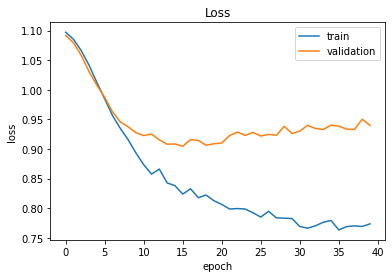

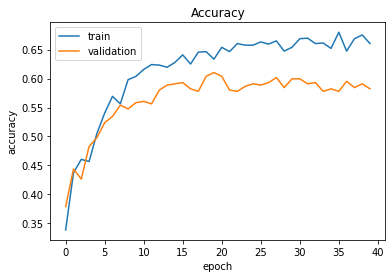

In [73]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [75]:
import operator
# negative, neutral, positive

def get_sentiment(values):
  max_index, max_value = max(enumerate(values), key=operator.itemgetter(1))
  if max_index == 0:
    return "negative"
  if max_index == 1:
    return "neutral"
  if max_index == 2:
    return "positive"
  return "mixed"

In [76]:
y_pred = model.predict(X_test)

In [77]:
y_pred = pd.DataFrame([get_sentiment(vals) for vals in y_pred])[0]
y_test = pd.DataFrame([get_sentiment(vals) for vals in y_test])[0]

In [78]:
dnn_report = classification_report(y_test, y_pred, output_dict=True)
print('accuracy: ', dnn_report['accuracy'])
print('macro avg: ', dnn_report['macro avg'])
print('positive: ', dnn_report['positive'])
print('negative: ', dnn_report['negative'])
print('neutral ', dnn_report['neutral'])

accuracy:  0.6103896103896104
macro avg:  {'precision': 0.6096825520697848, 'recall': 0.6083671011242526, 'f1-score': 0.6068465618108485, 'support': 462}
positive:  {'precision': 0.5838926174496645, 'recall': 0.5612903225806452, 'f1-score': 0.5723684210526315, 'support': 155}
negative:  {'precision': 0.6201550387596899, 'recall': 0.5405405405405406, 'f1-score': 0.5776173285198556, 'support': 148}
neutral  {'precision': 0.625, 'recall': 0.7232704402515723, 'f1-score': 0.6705539358600583, 'support': 159}


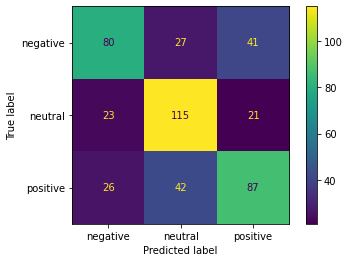

In [79]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

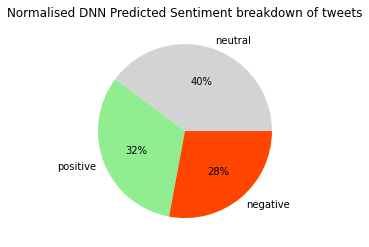

In [80]:
print_sentiment_breakdown(y_pred, "Normalised DNN Predicted Sentiment breakdown of tweets")